# Redoing $\sigma$ calculation for only the stars in the bulge

In [1]:
import sys
from brahma_analysis import *
from scipy.interpolate import interp1d
sys.path.append('/home/yja6qa/arepo_package/')

import arepo_package
import scipy.interpolate
import h5py
import os
import numpy as np
import plotting
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d

%matplotlib inline
radiative_efficiency=0.2

# New method: Gravitatioanl potential gradient, calculating $j_{circ}$ at given radius

In [3]:
# # Example usage of Center_subhalo
# TNGpath='/standard/torrey-group/IllustrisTNG/Runs/L75n1820TNG'
# basePath = TNGpath
# snap_num=99 # z=0
# subhalo_id = 0
# hdr  = il.groupcat.loadHeader(TNGpath, snap_num)
# h = hdr['HubbleParam'] ## load in h from the header
# box_size = hdr["BoxSize"]
# redshift = hdr['Redshift']

# fields = ['Masses','Coordinates','Velocities','Potential']
# Star_Props = il.snapshot.loadSubhalo(TNGpath, snap_num, id=subhalo_id, partType=4, fields=fields)
# Subhaloprops = il.groupcat.loadSubhalos(TNGpath,snap_num,fields=['SubhaloPos','SubhaloVel'])
# Coordinates,Velocities,Potentials = Center_subhalo(Star_Props,Subhaloprops,box_size,redshift,h,subhalo_id)
# ratio = kinematic_decomp(Coordinates,Velocities,Potentials)

In [2]:
from rotate import calc_incl, trans, center

TNGpath='/standard/torrey-group/IllustrisTNG/Runs/L75n1820TNG'
basePath = TNGpath
snap_num=99 # z=0
subhalo_id = 101
z = 0
a = 1/(1+z)

# Load in header file for cosmology
hdr  = il.groupcat.loadHeader(TNGpath, snap_num)
h = hdr['HubbleParam'] ## load in h from the header
box_size = hdr["BoxSize"]
    
# need to center coords on subhalo pos
SubhaloCM_pos = il.groupcat.loadSubhalos(TNGpath,snap_num,fields='SubhaloPos')[subhalo_id]
SubhaloCM_vel = il.groupcat.loadSubhalos(TNGpath,snap_num,fields='SubhaloVel')[subhalo_id]

fields = ['Masses','Coordinates','Velocities','Potential']
Star_Props = il.snapshot.loadSubhalo(TNGpath, snap_num, id=subhalo_id, partType=4, fields=fields)
# Shouldn't need mass?
star_coords, star_vel, star_mass, star_pot = Star_Props['Coordinates'], Star_Props['Velocities'], Star_Props['Masses'], Star_Props['Potential']

star_coords = center(star_coords,SubhaloCM_pos,box_size)
star_vel = star_vel - SubhaloCM_vel

# Correcting units, scale factor = 1 for z = 0
star_coords *= a/h # New units: kpc
kpc2km = 3.0857e16 # Conversion rate from kpc to km
star_coords *= kpc2km # New units: km
star_vel *= np.sqrt(a) # New units: km/s
star_pot /= a # New units: (km/s)^2

ri   = 0 * kpc2km  # from 0
ro   = 20 * kpc2km # to 20 kpc
incl = calc_incl(star_coords, star_vel, star_mass, ri, ro) ## rotate based on stars

star_coord_trans = trans(star_coords, incl)
star_vel_trans = trans(star_vel, incl)


## Next step: Sample stars at different radial bins and calculate potential gradient

In [64]:
r = np.sqrt(star_coord_trans[:,0]**2 + star_coord_trans[:,1]**2)

height = 1 * kpc2km # kpc for height of disk
ri   = 0 * kpc2km  # from 0
ro   = np.max(r) # to 20 kpcs
nbins = 100 # 100 bins from 0 to 20 kpc gives gradient res of 1/5 kpc
n = 50 # Number of stars to require and sample from

bins = np.linspace(ri,ro,nbins)

# Only stars within the height of the disk
disk_mask = (star_coord_trans[:,2] > -height) & (star_coord_trans[:,2] < height)
disk_coords = star_coord_trans[disk_mask]
disk_pot = star_pot[disk_mask]
r_disk = r[disk_mask]    

# Potentials at each radial bin
potentials = []

for i in range(len(bins)-1):
    
    # Mask of stars within the current radial bin
    r_mask = (r_disk > bins[i]) & (r_disk < bins[i+1])
    
    # Coordinates, potentials of stars in current bin
    r_bin = disk_coords[r_mask]
    r_pot = disk_pot[r_mask]
    
    # Require at least n stars in the radial bin to consider the radial potential well-defined
    if len(r_bin) < n:
        
        potentials.append(np.nan)
    
    # Otherwise, take the average of the potentials in the bin
    else:
        
        # Sample n potentials in the current radial bin
        # sample = np.random.choice(len(r_bin), size=n, replace=False)
        
        # Calculate mean potential
        potential = np.mean(r_pot)

        # Append to list
        potentials.append(potential)

In [65]:
# Positions in the middle of the bins
pos = np.array([np.mean([bins[n],bins[n+1]]) for n in range(0,len(bins)-1)])

# Calculating the gradient based on positions and potentials
grad = np.gradient(potentials,pos[1]-pos[0])

# Interpolating the gradient function with scipy 
gradient_interp = interp1d(pos, grad, kind='linear', fill_value="extrapolate")

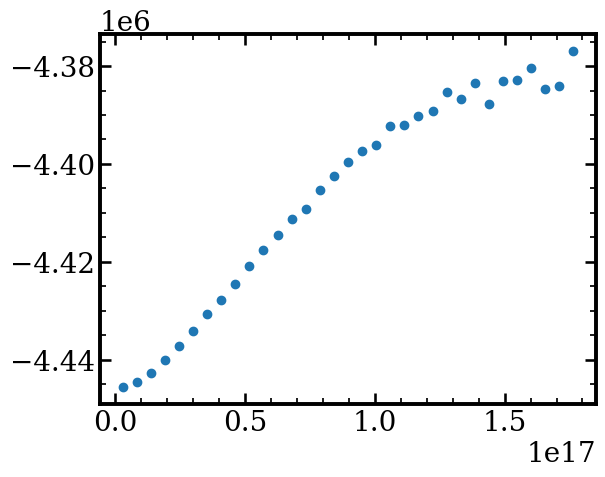

In [19]:
plt.scatter(pos,potentials)

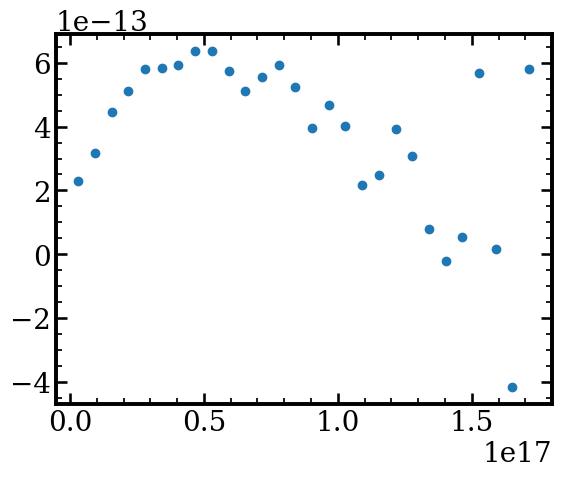

In [188]:
plt.scatter(pos,grad)

# Next step: Calculate circular angular momentum from interpolated potential gradient

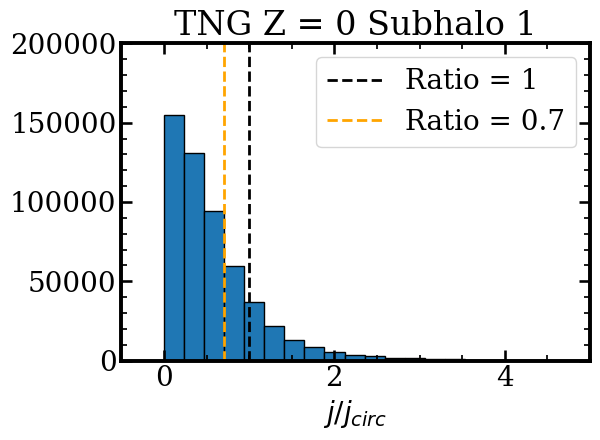

In [56]:
plt.hist(ratio[~np.isnan(ratio)],bins=350,edgecolor='black')
plt.vlines(1,0,200000,color = 'black',ls='--',lw=2,label = 'Ratio = 1')
plt.vlines(0.7,0,200000,color = 'orange',ls='--',lw=2,label = 'Ratio = 0.7')
plt.xlim(-0.5,5)
plt.ylim(0,200000)
plt.title('TNG Z = 0 Subhalo 1')
plt.xlabel('$j/j_{circ}$')
plt.legend()
plt.tight_layout()
plt.savefig('Plots/TNGz0_J_Jcirc_1.pdf')

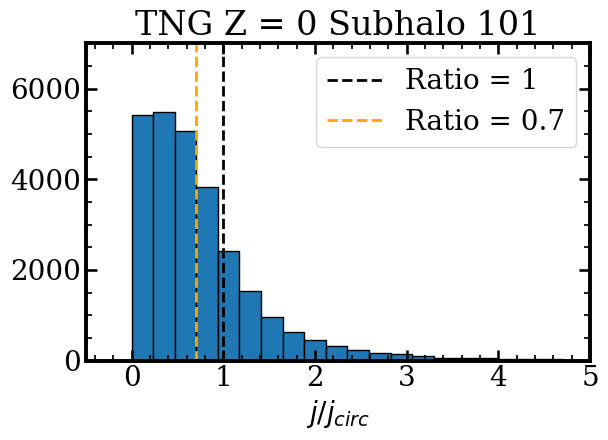

In [69]:
plt.hist(ratio[~np.isnan(ratio)],bins=150,edgecolor='black')
plt.vlines(1,0,7000,color = 'black',ls='--',lw=2,label = 'Ratio = 1')
plt.vlines(0.7,0,7000,color = 'orange',ls='--',lw=2,label = 'Ratio = 0.7')
plt.xlim(-0.5,5)
plt.ylim(0,7000)
plt.title('TNG Z = 0 Subhalo 101')
plt.xlabel('$j/j_{circ}$')
plt.legend()
plt.tight_layout()
plt.savefig('Plots/TNGz0_J_Jcirc_101.pdf')

# Comparing TNG z=0 with and without kinematic decomp:

In [2]:
TNGz0=ReadBrahmaData('Brahma_Data/TNG_z0')
TNGz0decomp = ReadBrahmaData('Brahma_Data/Kin_Decomp_TNG_z0')

In [3]:
TNGpath='/standard/torrey-group/IllustrisTNG/Runs/L75n1820TNG'
basePath = TNGpath
snap_num=99 # z=0
subhalo_id = 0
hdr  = il.groupcat.loadHeader(TNGpath, snap_num)
h = hdr['HubbleParam'] ## load in h from the header
box_size = hdr["BoxSize"]
redshift = hdr['Redshift']

In [4]:
Ratios,Sigmas,BH_Masses,Coords,Star_Masses,pos,grad = TNGz0decomp[0],TNGz0decomp[1],TNGz0decomp[2],TNGz0decomp[3],TNGz0decomp[4],TNGz0decomp[5],TNGz0decomp[6]
Sigmas = np.sqrt( np.array(Sigmas)[:,0]**2 + np.array(Sigmas)[:,1]**2 + np.array(Sigmas)[:,2]**2 ) 
BH_Masses = np.array(BH_Masses)*1e10/h
kpc2km = 3.0857e16
Coords = [np.array(Coords[i])/kpc2km for i in range(len(Coords))]

In [8]:
disks = [len(Ratios[i][(Ratios[i] > 0.7) & (Ratios[i] < 1.3)])/len(Ratios[i]) for i in range(len(Ratios))]

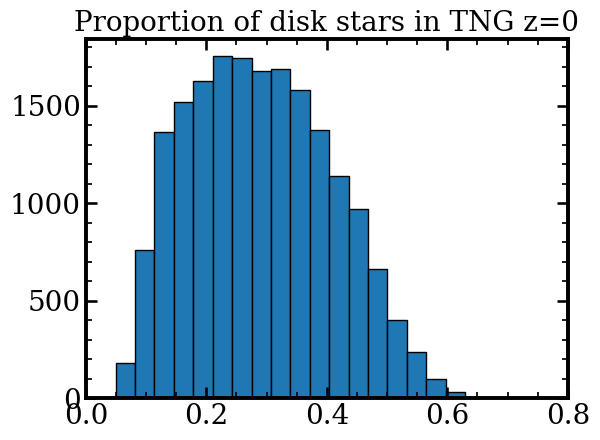

In [9]:
plt.hist(disks,bins=20,edgecolor='black')
plt.title('Proportion of disk stars in TNG z=0',size=20)
plt.xlim(0,0.8)
plt.tight_layout()
plt.savefig('Plots/Prop_disks.png')

In [8]:
# Binning as above for Illustris and Illustris TNG
Sigma_TNGz0 = np.sqrt(np.array(TNGz0[4])[:,0]**2 + np.array(TNGz0[4])[:,1]**2 + np.array(TNGz0[4])[:,2]**2 )

M_TNG = np.array(TNGz0[0])
bins=np.linspace(0.6,2.7,10)

Bulge_Means,Bulge_StdDevs,Bulge_xpoints = cal_avg(Sigmas,np.array(BH_Masses),bins)
bins=np.linspace(0.61,2.71,10)

TNG_Means,TNG_StdDevs,TNG_xpoints = cal_avg(Sigma_TNGz0,M_TNG,bins)


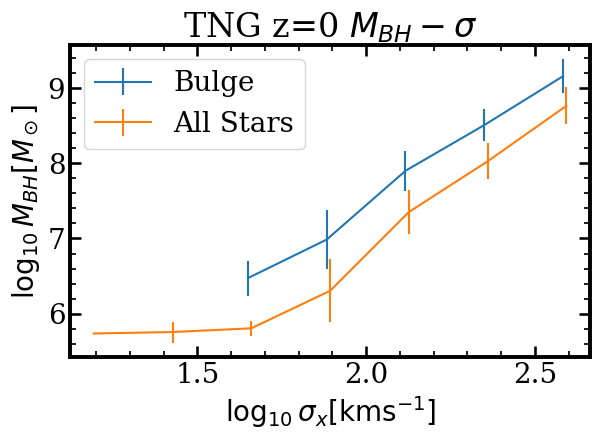

In [9]:
plt.errorbar(Bulge_xpoints,Bulge_Means,Bulge_StdDevs,label='Bulge')
plt.errorbar(TNG_xpoints,TNG_Means,TNG_StdDevs,label='All Stars')
plt.title('TNG z=0 $M_{BH}-\sigma$')
plt.xlabel('$\log_{10} \sigma_x \mathrm{[km s^{-1}]}$')
plt.ylabel('$\log_{10} M_{BH} [M_\odot]$')
plt.legend()
plt.tight_layout()
plt.savefig('Plots/TNG_MSigma_Bulge_comparison.png')

Want to plot ratio of j_z/j_circ to radial distance: if our decomposition is working properly, we should see a positive trend!

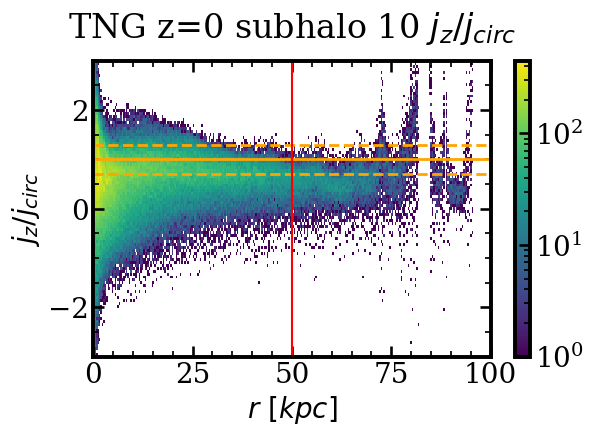

In [143]:
index=10
r = np.array([np.sqrt(Coords[index][i][0]**2 + Coords[index][i][1]**2) for i in range(len(Coords[index]))])
fig,ax=plt.subplots()
no_nans = ~np.isnan(Ratios[index])

counts1, xedges1, yedges1, im1 = ax.hist2d(r[no_nans],Ratios[index][no_nans],norm='log',bins=500)
fig.colorbar(im1, ax=ax)
ax.hlines([0.7,1.3],0,100,color='orange',lw=2,ls = '--')
ax.hlines(1,0,100,color='orange',lw=2)
ax.vlines(50,-3,3,color='red')
ax.set_ylim(-3,3)
ax.set_xlim(0,100)
plt.xlabel('$r\ [kpc]$')
plt.ylabel('$j_z/j_{circ}$')
plt.title('TNG z=0 subhalo 10 $j_z/j_{circ}$',y=1.05)
plt.tight_layout()
plt.savefig('Plots/jz_jcirc_TNG_subhalo_{}.png'.format(index))

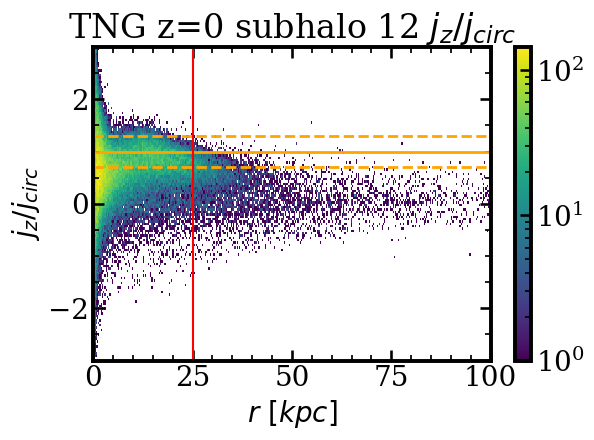

In [153]:
index=12
r = np.array([np.sqrt(Coords[index][i][0]**2 + Coords[index][i][1]**2) for i in range(len(Coords[index]))])
fig,ax=plt.subplots()

counts1, xedges1, yedges1, im1 = ax.hist2d(r[~np.isnan(Ratios[index])],Ratios[index][~np.isnan(Ratios[index])],
                                           norm='log',bins=500)
fig.colorbar(im1, ax=ax)
ax.hlines([0.7,1.3],0,100,color='orange',lw=2,ls = '--')
ax.hlines(1,0,100,color='orange',lw=2)
ax.vlines(25,-3,3,color='red')
plt.xlim(0,100)
plt.ylim(-3,3)
plt.xlabel('$r\ [kpc]$')
plt.ylabel('$j_z/j_{circ}$')
plt.title('TNG z=0 subhalo 12 $j_z/j_{circ}$')
plt.tight_layout()
plt.savefig('Plots/jz_jcirc_TNG_subhalo_{}.png'.format(index))

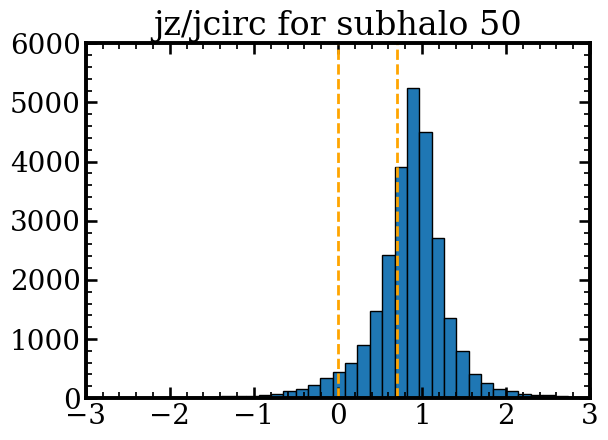

In [155]:
plt.hist(Ratios[50],bins=200,edgecolor='black')
plt.vlines([0,0.7],0,20000,color='orange',lw=2,ls='--')
plt.ylim(0,6000)
plt.xlim(-3,3)
plt.title('jz/jcirc for subhalo 50')
plt.tight_layout()
plt.savefig('Plots/TNGz0_J_Jcirc_50.pdf')

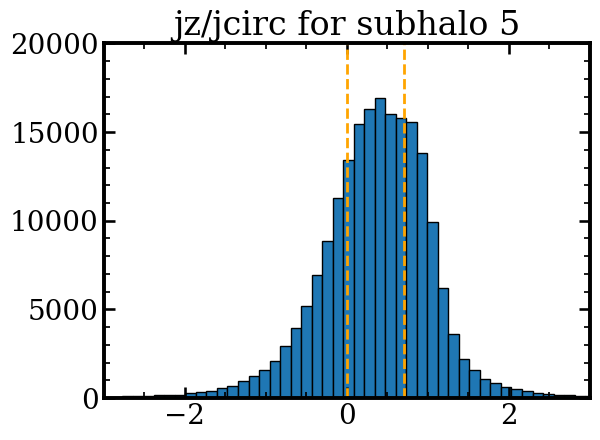

In [156]:
plt.hist(Ratios[5],bins=250,edgecolor='black')
plt.vlines([0,0.7],0,20000,color='orange',lw=2,ls='--')
plt.ylim(0,20000)
plt.xlim(-3,3)
plt.title('jz/jcirc for subhalo 5')
plt.tight_layout()
plt.savefig('Plots/TNGz0_J_Jcirc_5.pdf')

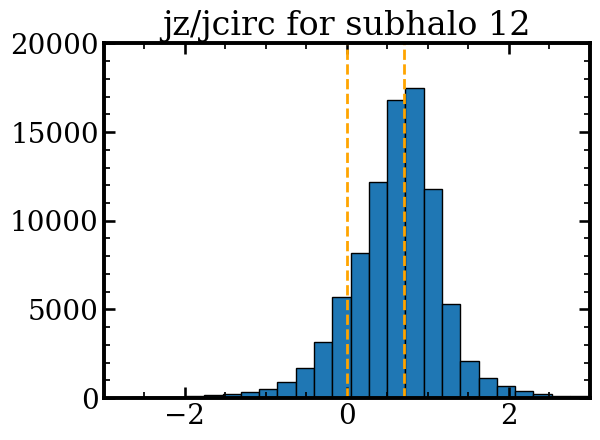

In [157]:
plt.hist(Ratios[12],bins=100,edgecolor='black')
plt.vlines([0,0.7],0,20000,color='orange',lw=2,ls='--')
plt.ylim(0,20000)
plt.xlim(-3,3)
plt.title('jz/jcirc for subhalo 12')
plt.tight_layout()
plt.savefig('Plots/TNGz0_J_Jcirc_12.pdf')

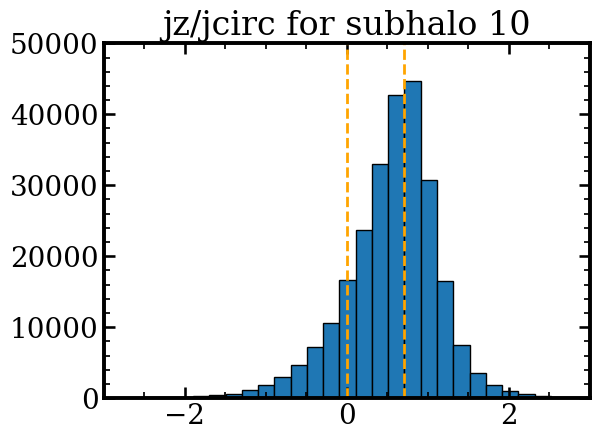

In [158]:
plt.hist(Ratios[10],bins=150,edgecolor='black')
plt.vlines([0,0.7],0,50000,color='orange',lw=2,ls='--')
plt.ylim(0,50000)
plt.xlim(-3,3)
plt.title('jz/jcirc for subhalo 10')
plt.tight_layout()
plt.savefig('Plots/TNGz0_J_Jcirc_10.pdf')

# Making spatial plots to show stars that have been identified as part of the disk and bulge

In [5]:
disks = [(Ratios[i] > 0.7) & (Ratios[i] < 1.3) for i in range(len(Ratios))]
bulges = [Ratios[i] < 0.7 for i in range(len(Ratios))]

Arrays: Ratios,Sigmas,BH_Masses,Coords,Star_Masses

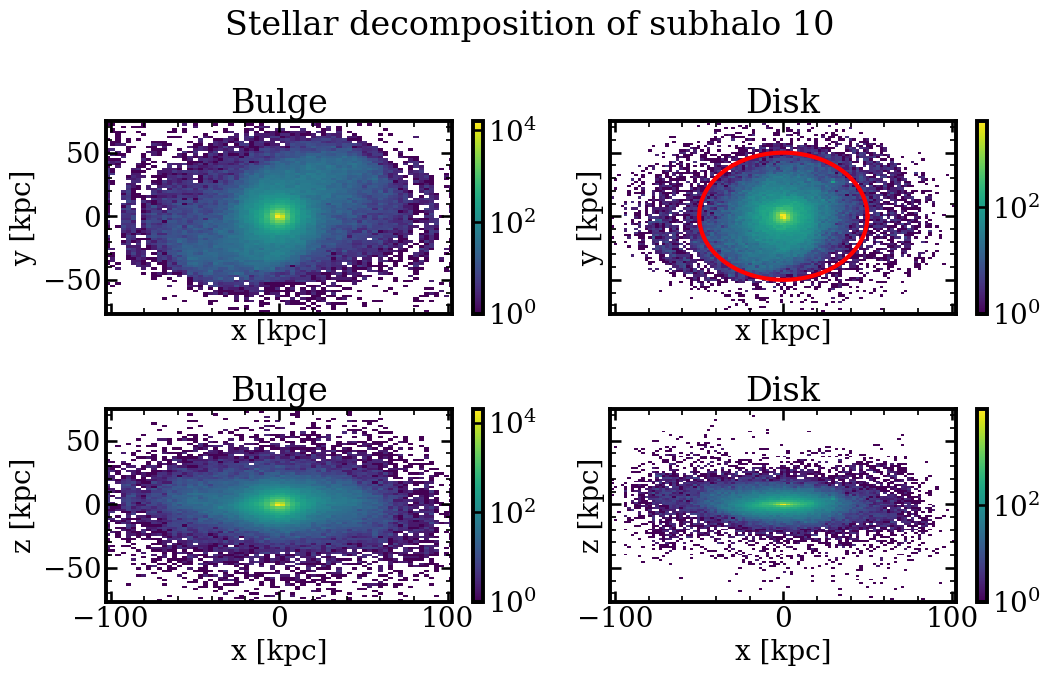

In [146]:
i = 10
rcrit = 50

x = np.linspace(-rcrit,rcrit,300)
y1 = np.sqrt(rcrit**2 - x**2)
y2 = -np.sqrt(rcrit**2 - x**2)

Bulge = Coords[i][bulges[i]]
Disk = Coords[i][disks[i]]

fig,axs=plt.subplots(2,2,figsize = (11,7),sharex=True,sharey=True)

# counts1, xedges1, yedges1, im1 = ax.hist2d(Coords[i][:,0],Coords[i][:,1],norm='log',bins=100)
counts1, xedges1, yedges1, im1 = axs[0,0].hist2d(Bulge[:,0],Bulge[:,1],norm='log',bins=100)
counts2, xedges2, yedges2, im2 = axs[0,1].hist2d(Disk[:,0],Disk[:,1],norm='log',bins=100)
axs[0,1].plot(x,y1,color='red',lw=3)
axs[0,1].plot(x,y2,color='red',lw=3)
axs[0,0].set_title('Bulge')
axs[0,1].set_title('Disk')
axs[0,0].set_xlabel('x [kpc]')
axs[0,1].set_xlabel('x [kpc]')
axs[0,0].set_ylabel('y [kpc]')
axs[0,1].set_ylabel('y [kpc]')

counts3, xedges3, yedges3, im3 = axs[1,0].hist2d(Bulge[:,0],Bulge[:,2],norm='log',bins=100)
counts4, xedges4, yedges4, im4 = axs[1,1].hist2d(Disk[:,0],Disk[:,2],norm='log',bins=100)

axs[1,0].set_title('Bulge')
axs[1,1].set_title('Disk')
axs[1,0].set_xlabel('x [kpc]')
axs[1,1].set_xlabel('x [kpc]')
axs[1,0].set_ylabel('z [kpc]')
axs[1,1].set_ylabel('z [kpc]')

fig.colorbar(im1, ax=axs[0,0])
fig.colorbar(im2, ax=axs[0,1])
fig.colorbar(im3, ax=axs[1,0])
fig.colorbar(im4, ax=axs[1,1])

fig.suptitle('Stellar decomposition of subhalo {}'.format(i))

fig.tight_layout()
fig.savefig('Plots/Subhalo_{}_decomp.png'.format(i))

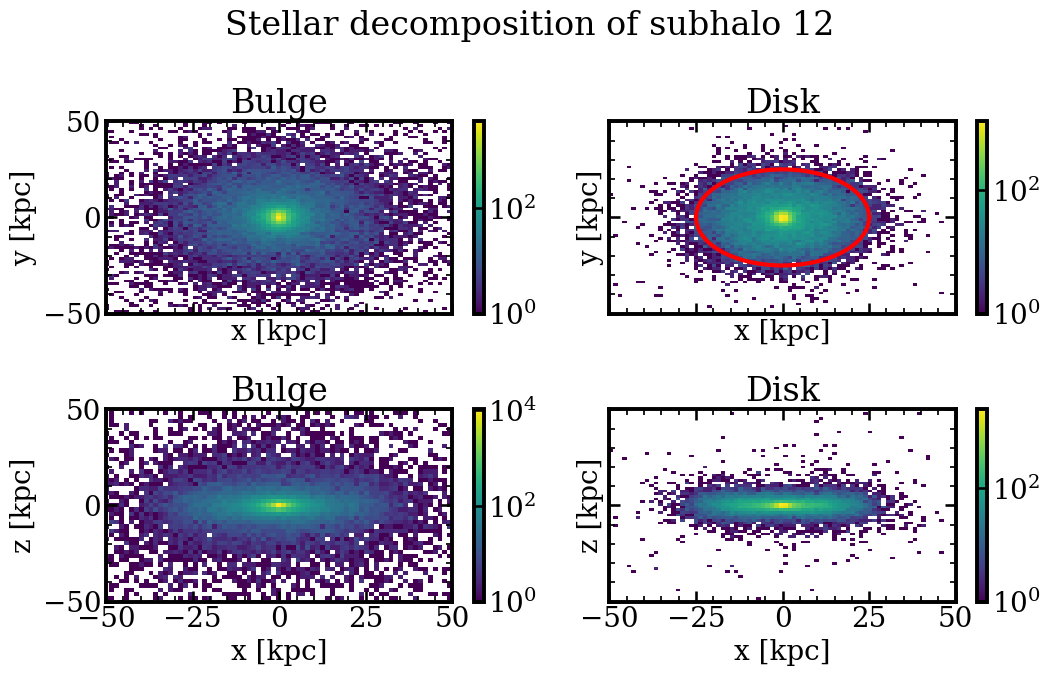

In [7]:
i = 12
rcrit = 25

x = np.linspace(-rcrit,rcrit,300)
y1 = np.sqrt(rcrit**2 - x**2)
y2 = -np.sqrt(rcrit**2 - x**2)

Bulge = Coords[i][bulges[i]]
Disk = Coords[i][disks[i]]

fig,axs=plt.subplots(2,2,figsize = (11,7),sharex=True,sharey=True)

# counts1, xedges1, yedges1, im1 = ax.hist2d(Coords[i][:,0],Coords[i][:,1],norm='log',bins=100)
counts1, xedges1, yedges1, im1 = axs[0,0].hist2d(Bulge[:,0],Bulge[:,1],norm='log',bins=200)
counts2, xedges2, yedges2, im2 = axs[0,1].hist2d(Disk[:,0],Disk[:,1],norm='log',bins=200)
axs[0,1].plot(x,y1,color='red',lw=3)
axs[0,1].plot(x,y2,color='red',lw=3)
axs[0,0].set_title('Bulge')
axs[0,1].set_title('Disk')
axs[0,0].set_xlabel('x [kpc]')
axs[0,1].set_xlabel('x [kpc]')
axs[0,0].set_ylabel('y [kpc]')
axs[0,1].set_ylabel('y [kpc]')

counts3, xedges3, yedges3, im3 = axs[1,0].hist2d(Bulge[:,0],Bulge[:,2],norm='log',bins=200)
counts4, xedges4, yedges4, im4 = axs[1,1].hist2d(Disk[:,0],Disk[:,2],norm='log',bins=200)

axs[1,0].set_title('Bulge')
axs[1,1].set_title('Disk')
axs[1,0].set_xlabel('x [kpc]')
axs[1,1].set_xlabel('x [kpc]')
axs[1,0].set_ylabel('z [kpc]')
axs[1,1].set_ylabel('z [kpc]')

for ax in axs.flatten():
    ax.set_xlim(-50,50)
    ax.set_ylim(-50,50)
    
fig.colorbar(im1, ax=axs[0,0])
fig.colorbar(im2, ax=axs[0,1])
fig.colorbar(im3, ax=axs[1,0])
fig.colorbar(im4, ax=axs[1,1])

fig.suptitle('Stellar decomposition of subhalo {}'.format(i))

fig.tight_layout()
fig.savefig('Plots/Subhalo_{}_decomp.png'.format(i))

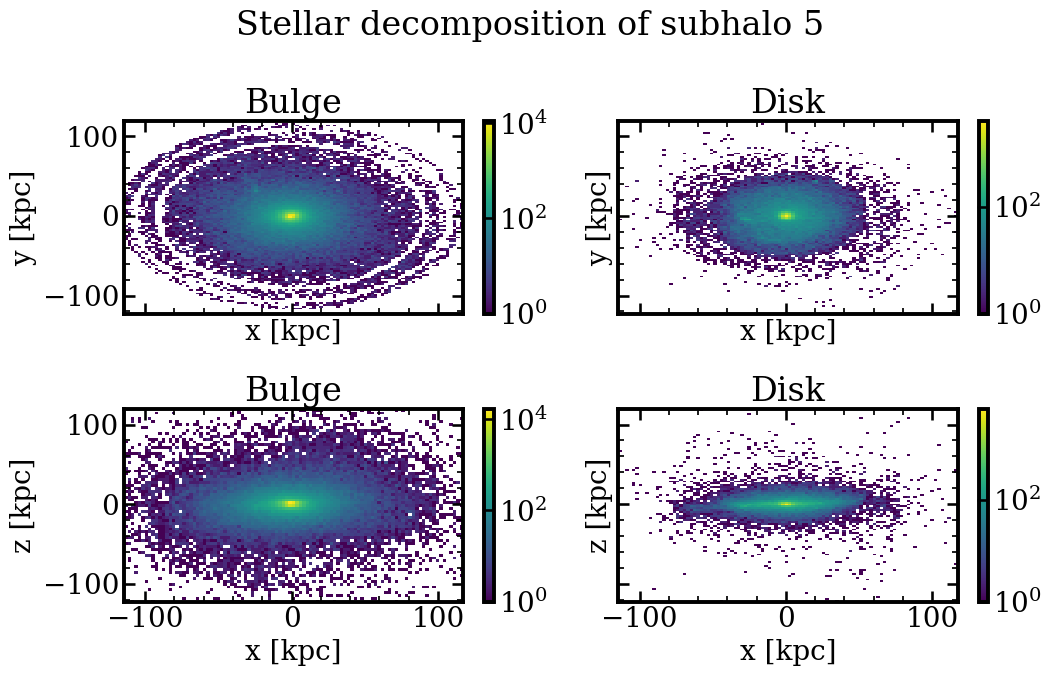

In [91]:
i = 5

Bulge = Coords[i][bulges[i]]
Disk = Coords[i][disks[i]]

fig,axs=plt.subplots(2,2,figsize = (11,7),sharex=True,sharey=True)

# counts1, xedges1, yedges1, im1 = ax.hist2d(Coords[i][:,0],Coords[i][:,1],norm='log',bins=100)
counts1, xedges1, yedges1, im1 = axs[0,0].hist2d(Bulge[:,0],Bulge[:,1],norm='log',bins=100)
counts2, xedges2, yedges2, im2 = axs[0,1].hist2d(Disk[:,0],Disk[:,1],norm='log',bins=100)
axs[0,0].set_title('Bulge')
axs[0,1].set_title('Disk')
axs[0,0].set_xlabel('x [kpc]')
axs[0,1].set_xlabel('x [kpc]')
axs[0,0].set_ylabel('y [kpc]')
axs[0,1].set_ylabel('y [kpc]')

counts3, xedges3, yedges3, im3 = axs[1,0].hist2d(Bulge[:,0],Bulge[:,2],norm='log',bins=100)
counts4, xedges4, yedges4, im4 = axs[1,1].hist2d(Disk[:,0],Disk[:,2],norm='log',bins=100)

axs[1,0].set_title('Bulge')
axs[1,1].set_title('Disk')
axs[1,0].set_xlabel('x [kpc]')
axs[1,1].set_xlabel('x [kpc]')
axs[1,0].set_ylabel('z [kpc]')
axs[1,1].set_ylabel('z [kpc]')

fig.colorbar(im1, ax=axs[0,0])
fig.colorbar(im2, ax=axs[0,1])
fig.colorbar(im3, ax=axs[1,0])
fig.colorbar(im4, ax=axs[1,1])

fig.suptitle('Stellar decomposition of subhalo {}'.format(i))

fig.tight_layout()
fig.savefig('Plots/Subhalo_{}_decomp.png'.format(i))

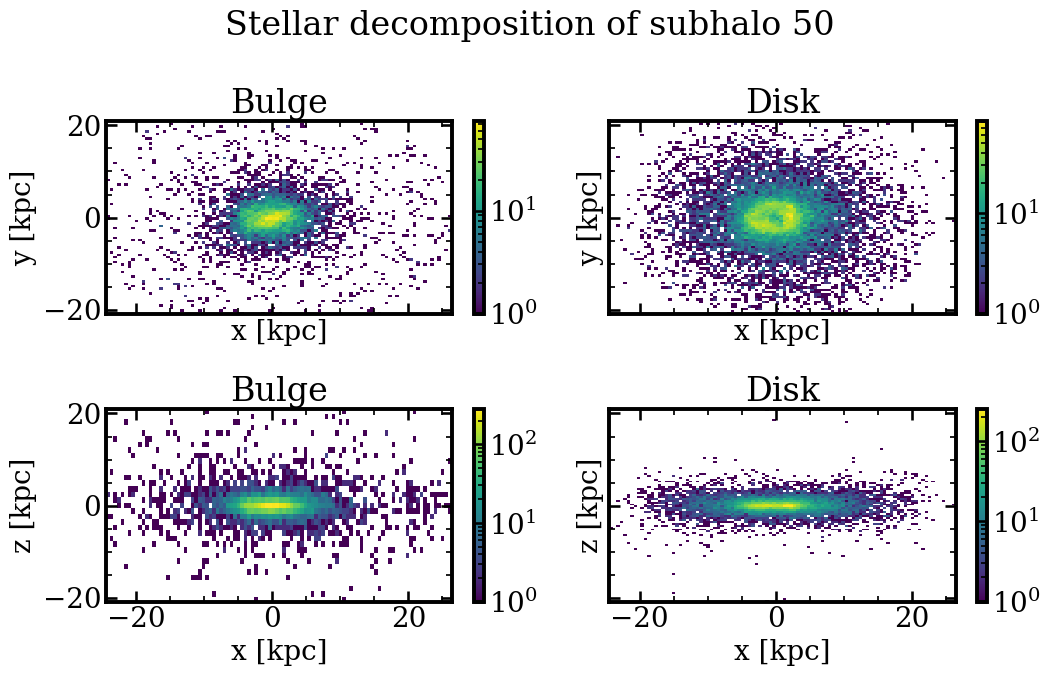

In [92]:
i = 50

Bulge = Coords[i][bulges[i]]
Disk = Coords[i][disks[i]]

fig,axs=plt.subplots(2,2,figsize = (11,7),sharex=True,sharey=True)

# counts1, xedges1, yedges1, im1 = ax.hist2d(Coords[i][:,0],Coords[i][:,1],norm='log',bins=100)
counts1, xedges1, yedges1, im1 = axs[0,0].hist2d(Bulge[:,0],Bulge[:,1],norm='log',bins=100)
counts2, xedges2, yedges2, im2 = axs[0,1].hist2d(Disk[:,0],Disk[:,1],norm='log',bins=100)
axs[0,0].set_title('Bulge')
axs[0,1].set_title('Disk')
axs[0,0].set_xlabel('x [kpc]')
axs[0,1].set_xlabel('x [kpc]')
axs[0,0].set_ylabel('y [kpc]')
axs[0,1].set_ylabel('y [kpc]')

counts3, xedges3, yedges3, im3 = axs[1,0].hist2d(Bulge[:,0],Bulge[:,2],norm='log',bins=100)
counts4, xedges4, yedges4, im4 = axs[1,1].hist2d(Disk[:,0],Disk[:,2],norm='log',bins=100)

axs[1,0].set_title('Bulge')
axs[1,1].set_title('Disk')
axs[1,0].set_xlabel('x [kpc]')
axs[1,1].set_xlabel('x [kpc]')
axs[1,0].set_ylabel('z [kpc]')
axs[1,1].set_ylabel('z [kpc]')

fig.colorbar(im1, ax=axs[0,0])
fig.colorbar(im2, ax=axs[0,1])
fig.colorbar(im3, ax=axs[1,0])
fig.colorbar(im4, ax=axs[1,1])

fig.suptitle('Stellar decomposition of subhalo {}'.format(i))

fig.tight_layout()
fig.savefig('Plots/Subhalo_{}_decomp.png'.format(i))

# Now with j_z/j_circ = 0.5 cutoff:

In [2]:
TNGz0=ReadBrahmaData('Brahma_Data/TNG_z0')
TNGz0decomp_5 = ReadBrahmaData('Brahma_Data/Kin_Decomp_TNG_z0_r0.5')

TNGpath='/standard/torrey-group/IllustrisTNG/Runs/L75n1820TNG'
basePath = TNGpath
snap_num=99 # z=0
subhalo_id = 0
hdr  = il.groupcat.loadHeader(TNGpath, snap_num)
h = hdr['HubbleParam'] ## load in h from the header
box_size = hdr["BoxSize"]
redshift = hdr['Redshift']

In [3]:
Ratios,Sigmas,BH_Masses,Coords,Star_Masses,pos,grad,Pot_E_norms,Central_subhalos = TNGz0decomp_5[0],TNGz0decomp_5[1],TNGz0decomp_5[2],TNGz0decomp_5[3],TNGz0decomp_5[4],TNGz0decomp_5[5],TNGz0decomp_5[6],TNGz0decomp_5[7],TNGz0decomp_5[8]
Sigmas = np.sqrt( np.array(Sigmas)[:,0]**2 + np.array(Sigmas)[:,1]**2 + np.array(Sigmas)[:,2]**2 ) 
BH_Masses = np.array(BH_Masses)*1e10/h
kpc2km = 3.0857e16
Coords = [np.array(Coords[i])/kpc2km for i in range(len(Coords))]

In [4]:
# Binning as above for Illustris and Illustris TNG
Sigma_TNGz0 = np.sqrt(np.array(TNGz0[4])[:,0]**2+np.array(TNGz0[4])[:,1]**2+np.array(TNGz0[4])[:,2]**2)

M_TNG = np.array(TNGz0[0])
bins=np.linspace(0.6,2.7,10)

Bulge_Means,Bulge_StdDevs,Bulge_xpoints = cal_avg(Sigmas,np.array(BH_Masses),bins)
bins=np.linspace(0.61,2.71,10)

TNG_Means,TNG_StdDevs,TNG_xpoints = cal_avg(Sigma_TNGz0,M_TNG,bins)


/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in divide
 

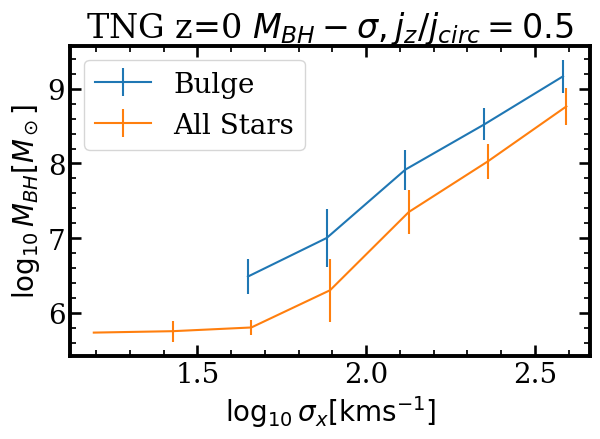

In [5]:
plt.errorbar(Bulge_xpoints,Bulge_Means,Bulge_StdDevs,label='Bulge')
plt.errorbar(TNG_xpoints,TNG_Means,TNG_StdDevs,label='All Stars')
plt.title('TNG z=0 $M_{BH}-\sigma, j_z/j_{circ} = 0.5$')
plt.xlabel('$\log_{10} \sigma_x \mathrm{[km s^{-1}]}$')
plt.ylabel('$\log_{10} M_{BH} [M_\odot]$')
plt.legend()
plt.tight_layout()
plt.savefig('Plots/TNG_MSigma_Bulge_comparison_0.5.png')

## Now: Plotting e/emax vs jz/jcirc like in https://iopscience.iop.org/article/10.3847/1538-4357/ab8fa8/pdf

Text(0.5, 1.0, 'TNG z=0 subhalo 12')

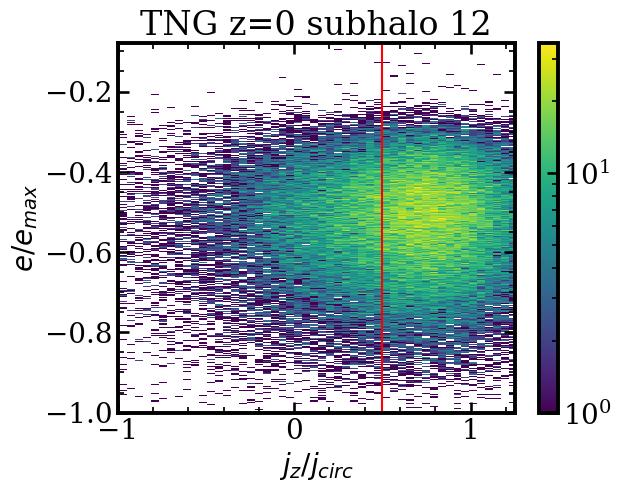

In [26]:
index=12
fig,ax=plt.subplots()

no_nans=~np.isnan(Ratios[index])
counts1, xedges1, yedges1, im1 = ax.hist2d(Ratios[index][no_nans],Pot_E_norms[index][no_nans],norm='log',bins=500)

fig.colorbar(im1, ax=ax)
# ax.hlines([0.7,1.3],0,100,color='orange',lw=2,ls = '--')
# ax.hlines(1,0,100,color='orange',lw=2)
ax.vlines(0.5,-1,0,color='red')
plt.xlim(-1,1.25)
plt.xlabel('$j_z/j_{circ}$')
plt.ylabel('$e/e_{max}$')
plt.title('TNG z=0 subhalo 12')
#plt.tight_layout()
#plt.savefig('Plots/TNG_subhalo_{}_emax_jz.png'.format(index))

In [4]:
disks = [(Ratios[i] > 0.5) & (Ratios[i] < 1.3) for i in range(len(Ratios))]
bulges = [Ratios[i] < 0.5 for i in range(len(Ratios))]

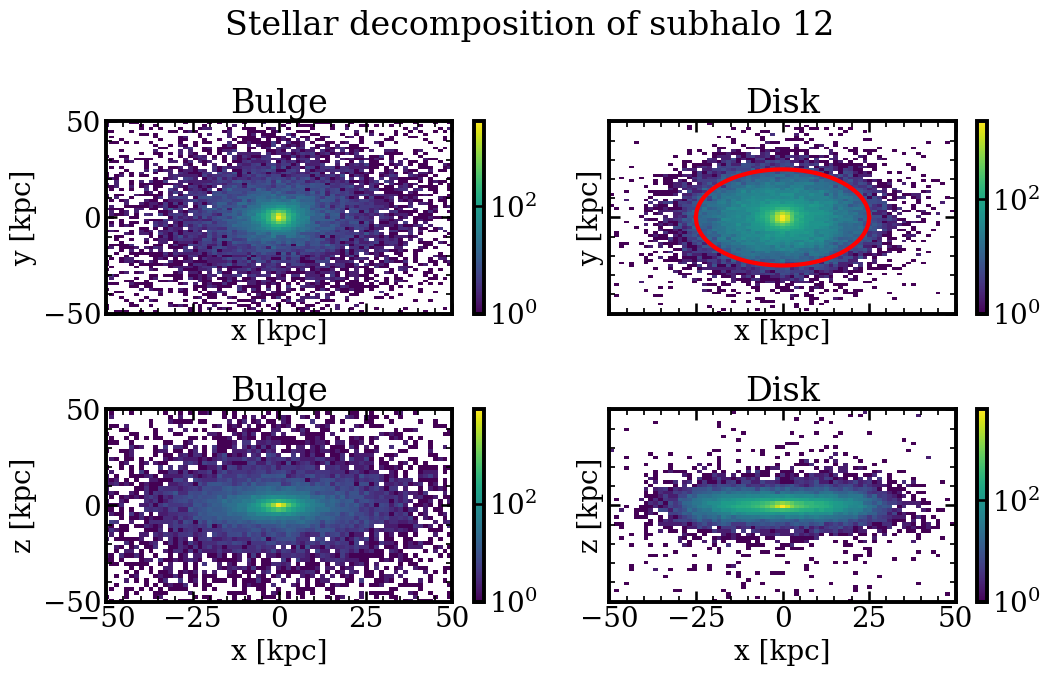

In [8]:
i = 12
rcrit = 25

x = np.linspace(-rcrit,rcrit,300)
y1 = np.sqrt(rcrit**2 - x**2)
y2 = -np.sqrt(rcrit**2 - x**2)

Bulge = Coords[i][bulges[i]]
Disk = Coords[i][disks[i]]

fig,axs=plt.subplots(2,2,figsize = (11,7),sharex=True,sharey=True)

# counts1, xedges1, yedges1, im1 = ax.hist2d(Coords[i][:,0],Coords[i][:,1],norm='log',bins=100)
counts1, xedges1, yedges1, im1 = axs[0,0].hist2d(Bulge[:,0],Bulge[:,1],norm='log',bins=200)
counts2, xedges2, yedges2, im2 = axs[0,1].hist2d(Disk[:,0],Disk[:,1],norm='log',bins=200)
axs[0,1].plot(x,y1,color='red',lw=3)
axs[0,1].plot(x,y2,color='red',lw=3)
axs[0,0].set_title('Bulge')
axs[0,1].set_title('Disk')
axs[0,0].set_xlabel('x [kpc]')
axs[0,1].set_xlabel('x [kpc]')
axs[0,0].set_ylabel('y [kpc]')
axs[0,1].set_ylabel('y [kpc]')

counts3, xedges3, yedges3, im3 = axs[1,0].hist2d(Bulge[:,0],Bulge[:,2],norm='log',bins=200)
counts4, xedges4, yedges4, im4 = axs[1,1].hist2d(Disk[:,0],Disk[:,2],norm='log',bins=200)

axs[1,0].set_title('Bulge')
axs[1,1].set_title('Disk')
axs[1,0].set_xlabel('x [kpc]')
axs[1,1].set_xlabel('x [kpc]')
axs[1,0].set_ylabel('z [kpc]')
axs[1,1].set_ylabel('z [kpc]')

for ax in axs.flatten():
    ax.set_xlim(-50,50)
    ax.set_ylim(-50,50)

fig.colorbar(im1, ax=axs[0,0])
fig.colorbar(im2, ax=axs[0,1])
fig.colorbar(im3, ax=axs[1,0])
fig.colorbar(im4, ax=axs[1,1])

fig.suptitle('Stellar decomposition of subhalo {}'.format(i))

fig.tight_layout()
fig.savefig('Plots/Subhalo_{}_decomp_0.5.png'.format(i))

## Want to plot average e/emax vs jz/jcirc to compare to above paper:

In [19]:
Ratios = [Ratios[i][~np.isnan(Ratios[i])] for i in range(len(Ratios))]
Avg_ratios = [np.mean(Ratios[i]) for i in range(len(Ratios))]
Pot_E_norms = [Pot_E_norms[i][(~np.isnan(Pot_E_norms[i])) & (Pot_E_norms[i]<0)] for i in range(len(Pot_E_norms))]
Avg_e = [np.mean(Pot_E_norms[i]) for i in range(len(Pot_E_norms))]

no_nans = ~np.isnan(Avg_e)

Avg_ratios = np.array(Avg_ratios)[no_nans]
Avg_e = np.array(Avg_e)[no_nans]

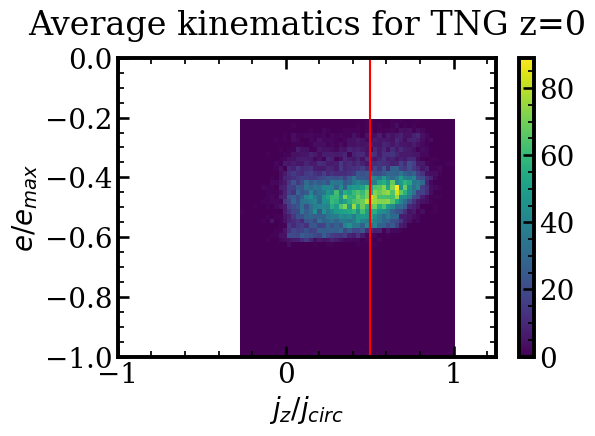

In [27]:
fig,ax=plt.subplots()

no_nans=~np.isnan(Ratios[index])
counts1, xedges1, yedges1, im1 = ax.hist2d(Avg_ratios,Avg_e,bins=50)

fig.colorbar(im1, ax=ax)
# ax.hlines([0.7,1.3],0,100,color='orange',lw=2,ls = '--')
# ax.hlines(1,0,100,color='orange',lw=2)
ax.vlines(0.5,-1,0,color='red')
plt.xlim(-1,1.25)
plt.ylim(-1,0)
plt.xlabel('$j_z/j_{circ}$')
plt.ylabel('$e/e_{max}$')
plt.title('Average kinematics for TNG z=0',y=1.05)
plt.tight_layout()
#plt.savefig('Plots/TNG_subhalo_{}_emax_jz.png'.format(index))

Didn't do mass-weighted averages... it looks like we are missing the "bulge" component though...

# Testing kinematic decomp function:

In [46]:
def kinematic_decomp(Coordinates,Velocities,Potentials,rbins=100,nstars_min=1000):
    
    # Only do decomposition if there are at least nstars_min stars
    if len(Coordinates)<nstars_min:
        return
    
    kpc2km = 3.0857e16 # Conversion rate from kpc to km
    # radial distance from subhalo center in the xy plane
    r = np.sqrt(Coordinates[:,0]**2 + Coordinates[:,1]**2)
    
    height = 3 * kpc2km # kpc for height of disk
    ri   = 0 * kpc2km  # from 0
    ro   = np.max(r) # to the max disk size of the subhalo
    n = 30 # Number of stars required per bin 
    nbins = 100 # 100 bins in disk
    
    bins = overlapping_bins(ri,ro,nbins,dx=0.5)

    # Only stars within the height of the disk
    disk_mask = (Coordinates[:,2] > -height) & (Coordinates[:,2] < height)
    disk_coords = Coordinates[disk_mask]
    disk_pot = Potentials[disk_mask]
    disk_r = r[disk_mask]    

    # Potentials at each radial bin
    potential_binned = np.zeros(shape=len(bins))

    for i in range(len(bins)):

        # Mask of stars within the current radial bin
        r_mask = (disk_r > bins[i][0]) & (disk_r < bins[i][1])

        # Coordinates, potentials of stars in current bin
        r_bin = disk_coords[r_mask]
        r_pot = disk_pot[r_mask]

        # Require at least n stars in the radial bin to consider the radial potential well-defined
        if len(r_bin) < n:
            potential_binned[i] = np.nan

        # Otherwise, take the average of the potentials in the bin
        else:

            # Calculate mean potential
            potential = np.mean(r_pot)

            # Append to list
            potential_binned[i] = potential
        
    # Removing nan values
    no_nans = ~np.isnan(potential_binned)
    potential_binned = potential_binned[no_nans]
            
    # Positions in the middle of the bins
    pos = np.array([np.mean(bins[n]) for n in range(len(bins))])
    
    # Removing nan potential indices from position
    pos = pos[no_nans]
    
    # Calculating the gradient based on positions and potentials
    grad = np.gradient(potential_binned,pos)
    # print("Positions:",pos,"Gradient:",grad)
        
    # Interpolating the gradient function with scipy 
    gradient_interp = interp1d(pos, grad, kind='linear', fill_value="extrapolate")
    
    # Take the absolute value of the interpolated gradients
    grad_phi_interp = np.array(gradient_interp(r))
    
    # Find ids of negative potential gradients
    neg_ids = grad_phi_interp < 0
    
    # Set negative potential gradients to np.nan
    grad_phi_interp[neg_ids] = np.nan
    
    # Calculate circular angular momentum
    v_circ = np.sqrt(r * grad_phi_interp)
    j_circ = r * v_circ
    
    # Calculate actual angular momentum
    j_z = np.cross(Coordinates,Velocities)[:,2]
    
    # Take the ratio of the two
    ratio=j_z/j_circ
    
    # Return the ratio of the angular momentums to the specific angular momentums
    return(pos,grad,ratio)

In [47]:
TNGpath='/standard/torrey-group/IllustrisTNG/Runs/L75n1820TNG'
basePath = TNGpath
snap_num=99 # z=0
hdr  = il.groupcat.loadHeader(basePath, snap_num)
h = hdr['HubbleParam'] ## load in h from the header
box_size = hdr["BoxSize"]
redshift = hdr['Redshift']

# Load in all subhalo positions and velocities 
Subhaloprops = il.groupcat.loadSubhalos(basePath,snap_num,fields=['SubhaloPos','SubhaloVel'])

Desired_subhalos = np.arange(20)

radii = []
gradients = []
ratios = []

# Now looping through all subhalos with BHs and 1000 stars
for index in Desired_subhalos:
    
    fields = ['BH_Mass']
    Subhalo_BH_Masses = il.snapshot.loadSubhalo(basePath, snapNum=snap_num, id=index, partType=5, fields=fields)
            
    # Load in star properties of current halo
    fields = ['Masses','Coordinates','Velocities','Potential']
    Star_Props = il.snapshot.loadSubhalo(basePath, snap_num, id=index, partType=4, fields=fields)
    Star_Mass=Star_Props['Masses']*1e10/h # Units: Msun
        
    # Center coord and vel and correct units
    Coordinates,Velocities,Potentials = Center_subhalo(Star_Props,Subhaloprops,box_size,redshift,h,subhalo_id=index)

    # Calculate id's of stars in the disk
    pos,gradient,ratio = kinematic_decomp(Coordinates,Velocities,Potentials)
    radii.append(pos)
    gradients.append(gradient)
    ratios.append(ratio)

(0.0, 2.0477610500727027e+18)

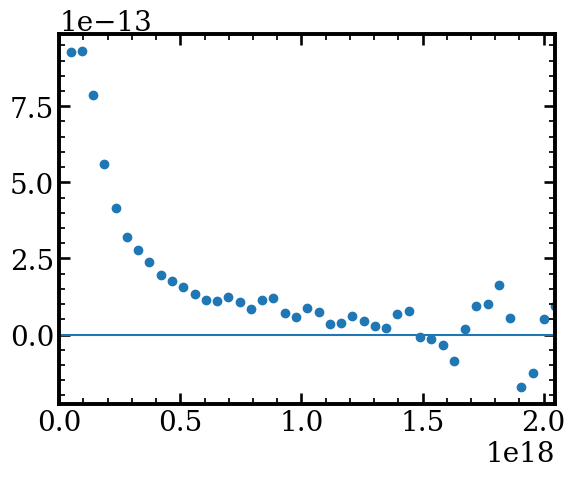

In [45]:
i = 14
plt.scatter(radii[i],gradients[i])
plt.hlines(0,0,1e19)
plt.xlim(0,np.max(radii[i]))